# IEEE Fraud Detection

Alunos : Victor e Lucas

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import f1_score, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_theme()

## 1 - Carregando os datasets

In [2]:
df_train_id = pd.read_csv("data/train_identity.csv")
df_train_tr = pd.read_csv("data/train_transaction.csv")
df_test_id = pd.read_csv("data/test_identity.csv")
df_test_tr = pd.read_csv("data/train_transaction.csv")

In [3]:
df_train_id.shape, df_train_tr.shape, df_test_id.shape, df_test_tr.shape

((144233, 41), (590540, 394), (141907, 41), (590540, 394))

In [4]:
df_train = pd.merge(df_train_tr, df_train_id, on='TransactionID', how='left')
df_test = pd.merge(df_test_tr, df_test_id, on='TransactionID', how='left')
df_test, df_val = train_test_split(df_test, test_size=0.2, random_state=42, stratify=df_test['isFraud'])

In [5]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(590540, 434)
(472432, 434)
(118108, 434)


In [6]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [12]:
df_test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
40809,3027809,0,1008491,100.00,R,6177,399.0,150.0,american express,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285886,3272886,0,7008212,29.99,W,7900,345.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104256,3091256,0,2071522,107.95,W,11690,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507860,3494860,0,13299752,241.95,W,2616,327.0,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196382,3183382,0,4412283,117.00,W,13780,298.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Variável alvo
target = df_train['isFraud'].value_counts()
target

0    569877
1     20663
Name: isFraud, dtype: int64

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [95]:
df_train.corr()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
TransactionID,1.000000,0.014166,0.998280,0.012025,0.010122,-0.019900,-0.010091,-0.023900,-0.000370,0.057213,...,0.222829,0.111975,-0.015030,0.084105,-0.029004,0.052621,-0.038339,0.020672,0.013670,-0.066437
isFraud,0.014166,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,...,0.150100,0.050004,-0.041721,0.061597,0.063544,0.118409,-0.001905,0.034045,0.099587,0.069702
TransactionDT,0.998280,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,...,0.214802,0.110234,-0.011815,0.082009,-0.024249,0.051437,-0.031312,0.020372,0.017790,-0.071392
TransactionAmt,0.012025,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,...,-0.334971,-0.096851,0.076174,-0.105866,-0.031840,-0.104620,0.080110,0.016145,0.023098,-0.041851
card1,0.010122,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,...,0.018892,0.008869,0.022617,0.015917,0.044073,0.016853,0.057550,-0.010192,0.078487,-0.009524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_22,0.052621,0.118409,0.051437,-0.104620,0.016853,-0.024013,0.657624,-0.180340,0.065780,-0.291785,...,0.591957,0.130109,0.063871,0.030765,0.070591,1.000000,0.014067,0.182643,0.281324,-0.041127
id_24,-0.038339,-0.001905,-0.031312,0.080110,0.057550,0.000844,0.011953,-0.018330,-0.032398,-0.037455,...,-0.014895,0.014321,0.245221,-0.189628,0.220933,0.014067,1.000000,-0.030902,0.086002,-0.219537
id_25,0.020672,0.034045,0.020372,0.016145,-0.010192,-0.009787,0.140797,-0.042232,-0.004287,0.004896,...,0.173535,0.108161,-0.008509,-0.028451,-0.147694,0.182643,-0.030902,1.000000,0.011508,0.027603
id_26,0.013670,0.099587,0.017790,0.023098,0.078487,0.006429,0.228904,-0.089528,0.050645,-0.067406,...,0.076164,-0.048799,0.116386,0.048413,0.053721,0.281324,0.086002,0.011508,1.000000,-0.065558


## 2 - Análise Exploratória

### Transaction Amount

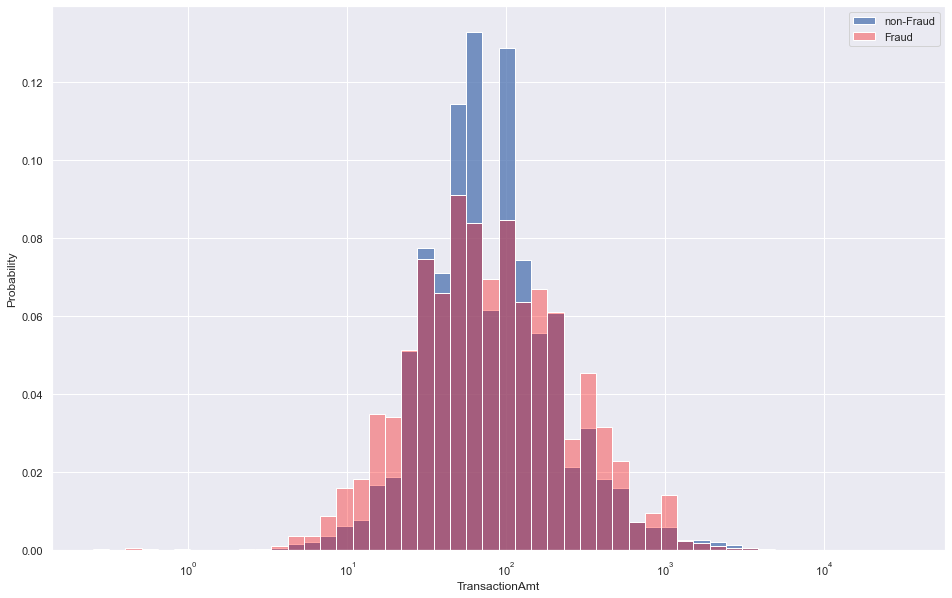

In [7]:
bins = np.histogram_bin_edges(np.log10(df_train['TransactionAmt']), bins=50)

plt.figure(figsize=(16,10))

# plt.subplot(121)
px = sns.histplot(data=df_train, x='TransactionAmt', label='non-Fraud',
                  bins=bins, stat='probability', log_scale=True)


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True], x='TransactionAmt', bins=bins,
                   stat='probability', log_scale=True, color='red', alpha=0.35, label='Fraud')


plt.legend()
plt.show()

### TransactionDT

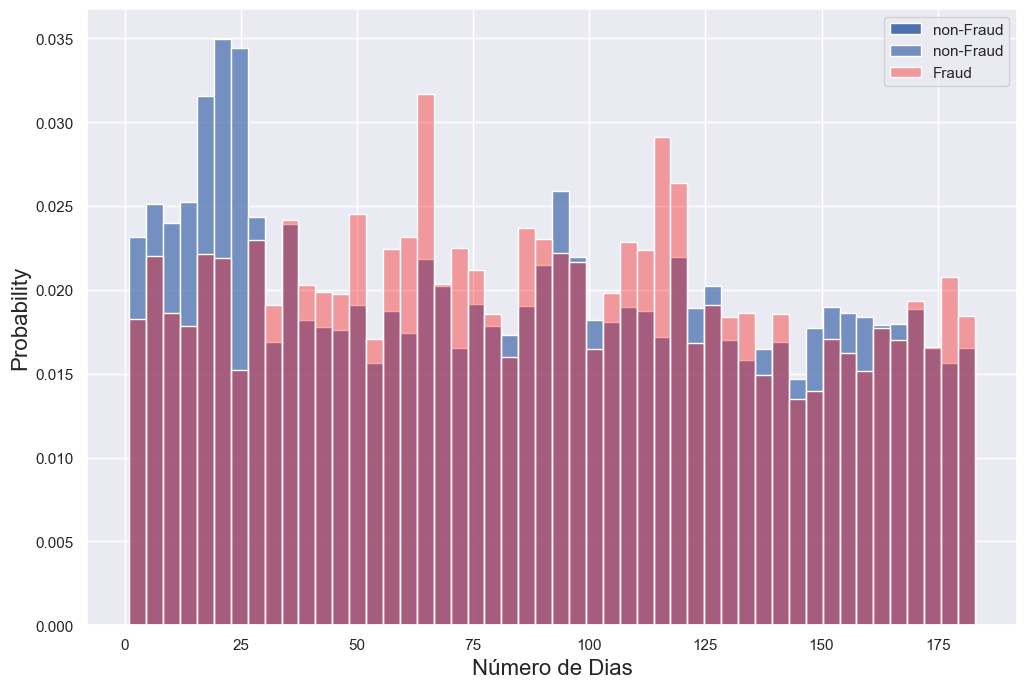

In [16]:
bins = np.histogram_bin_edges(df_train['TransactionDT'] / 86400, bins=50)

fig = plt.figure(figsize=(12,8))

# plt.subplot(121)
px = sns.histplot(data=df_train['TransactionDT'] / 86400, label='non-Fraud',
                  bins=bins, stat='probability')


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True]['TransactionDT'] / 86400, bins=bins,
                   stat='probability', color='red', alpha=0.35, label='Fraud')

px2.set_xlabel('Número de Dias', fontsize=16)
px2.set_ylabel('Probability', fontsize=16)
plt.legend()
plt.show()

In [17]:
#df_train[df_train.columns.difference(['TransactionID', 'TransactionDT', 'isFraud', 'TransactionAmt'])].hist(figsize=(20,348), layout=(87, 5), bins=30);

### Avaliando o tipo de aparelho em que a transação foi realizada

In [8]:
categorical_columns = df_train.select_dtypes(exclude=np.number).columns.to_list()

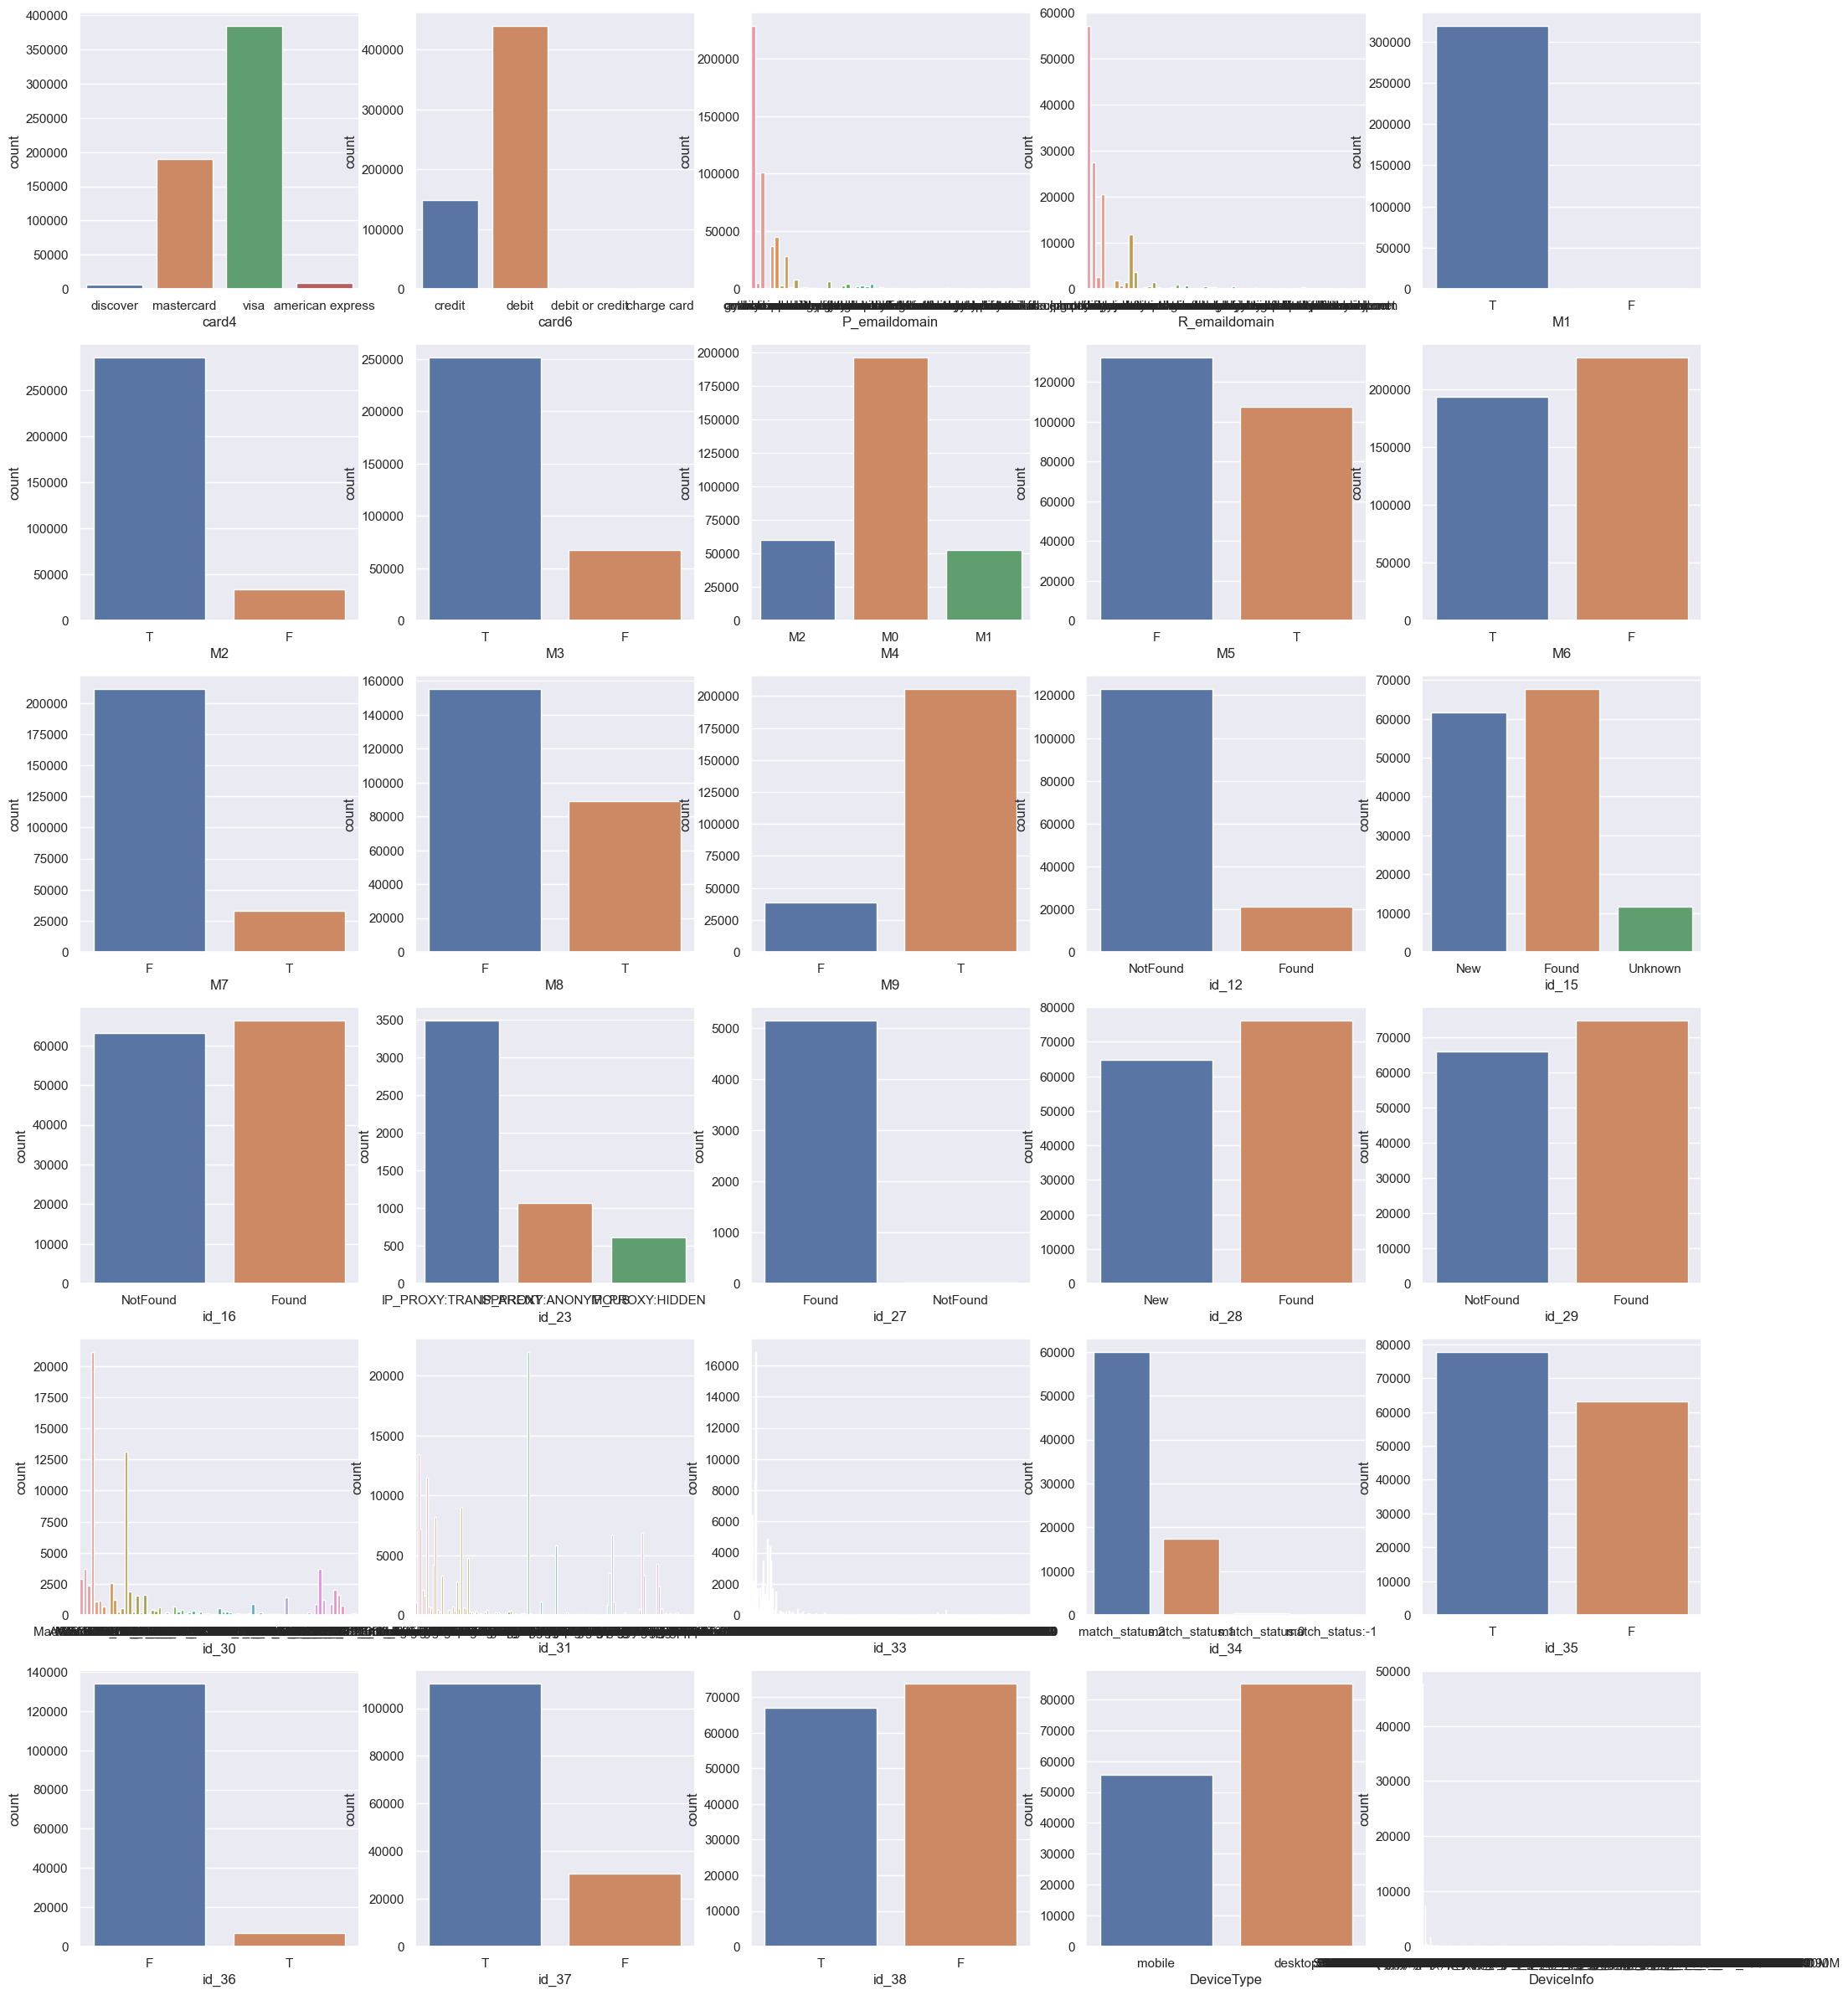

In [18]:


fig, axes = plt.subplots(6, 5, figsize=(25, 30))

aux = 1

for row in axes:
    for column in row:
        
        sns.countplot(data=df_train, x=categorical_columns[aux], ax=column)
        aux += 1


plt.show()

## 3 - Feature Engineering

### Fixing the problemns of 'id' columns with diff names

df_train -> ['id_01'] & df_val, df_test -> ['id-01']

In [9]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [10]:
len(df_train.columns) == len(df_test.columns)

True

In [11]:
columns_name = df_train.columns.to_list()

df_val.columns = columns_name
df_test.columns = columns_name

### P_emaildomain

In [12]:
df_train['P_emaildomain'].unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [13]:
# Reagrupando os domínios de e-mail (df_train)

def group_email_domain(pattern, email_domain, df):
    df['P_emaildomain'].replace(pattern, email_domain, regex=True, inplace=True)
    df['R_emaildomain'].replace(pattern, email_domain, regex=True, inplace=True)

gmail_match = re.compile(r'.*(gmail).*')

group_email_domain(gmail_match, 'gmail', df_train)
group_email_domain(gmail_match, 'gmail', df_test)
group_email_domain(gmail_match, 'gmail', df_val)

yahoo_match = re.compile(r'.*(yahoo).*')

group_email_domain(yahoo_match, 'yahoo', df_train)
group_email_domain(yahoo_match, 'yahoo', df_test)
group_email_domain(yahoo_match, 'yahoo', df_val)

microsoft_match = re.compile(r'.*(hotmail|outlook|live|msn).*')

group_email_domain(microsoft_match, 'microsoft', df_train)
group_email_domain(microsoft_match, 'microsoft', df_test)
group_email_domain(microsoft_match, 'microsoft', df_val)

others_match = re.compile(r'.*[^gmail|yahoo|microsoft].*')

group_email_domain(others_match, 'others', df_train)
group_email_domain(others_match, 'others', df_test)
group_email_domain(others_match, 'others', df_val)


In [24]:
df_test['R_emaildomain'].value_counts(normalize=True)

gmail        0.416140
microsoft    0.245635
others       0.238629
yahoo        0.099595
Name: R_emaildomain, dtype: float64

## DeviceInfo

In [38]:
len(df_train['DeviceInfo'].unique())

1787

In [39]:
df_train['DeviceInfo'].unique()

array([nan, 'SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'], dtype=object)

## 4 - Treinamento do Modelo

## Splitting data

In [14]:
def df_subset(df, size):
    df_sub = df.sample(frac=size, replace=False, random_state=42)

    return df_sub

df_train_05 = df_subset(df_train, 0.05)
df_train_10 = df_subset(df_train, 0.1)
df_train_20 = df_subset(df_train, 0.2)
df_train_50 = df_subset(df_train, 0.5)


for df in [df_train_05, df_train_10, df_train_20, df_train_50, df_train]:
    print(df.shape[0])

29527
59054
118108
295270
590540


In [15]:
def split_x_y(df):
    X = df.drop(['isFraud'], axis=1)
    y = df.loc[:, 'isFraud']
    
    return X, y

X_train_05, y_train_05 = split_x_y(df_train_05)
X_train_10, y_train_10 = split_x_y(df_train_10)
X_train_20, y_train_20 = split_x_y(df_train_20)
X_train_50, y_train_50 = split_x_y(df_train_50)
X_train, y_train = split_x_y(df_train)

X_val, y_val = split_x_y(df_val)

X_test, y_test = split_x_y(df_test)


### Baseline

In [102]:
encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns)
)

def baseline(X_train, y_train, X_val, y_val):

    pipe = make_pipeline(
        encode_categorical,
        RandomForestClassifier(min_samples_split=10, class_weight='balanced', random_state=42, n_estimators=50, n_jobs=-1)
        )
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    
    print(f"Val ROC AUC score: {roc_auc_score(y_val, y_pred)}")

    return roc_auc_score(y_val, y_pred)

In [103]:
import time
roc = []

for (x_train_, y_train_) in [
    (X_train_05, y_train_05),
    (X_train_10, y_train_10),
    (X_train_20, y_train_20),
    (X_train_50, y_train_50),
    (X_train, y_train)
]:
    now = time.time()
    print(f"Training with {x_train_.shape[0]} samples ({x_train_.shape[0] / df_train.shape[0]:.0%})")
    roc.append(baseline(x_train_, y_train_, X_val, y_val))
    end = time.time()
    print(f"Time elapsed: {end - now} seconds\n")

Training with 29527 samples (5%)
Val ROC AUC score: 0.5853394165811722
Time elapsed: 5.791107177734375 seconds

Training with 59054 samples (10%)
Val ROC AUC score: 0.5929643456836878
Time elapsed: 12.513861656188965 seconds

Training with 118108 samples (20%)
Val ROC AUC score: 0.6720602651039171
Time elapsed: 30.37678551673889 seconds

Training with 295270 samples (50%)
Val ROC AUC score: 0.6927069297683563
Time elapsed: 112.95466804504395 seconds

Training with 590540 samples (100%)
Val ROC AUC score: 0.7140257760882973
Time elapsed: 348.9866769313812 seconds



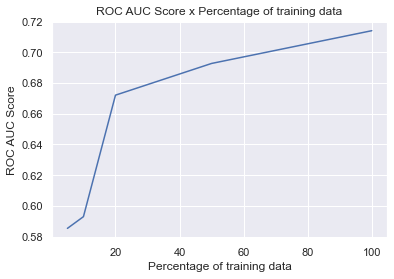

In [104]:
g = sns.lineplot(x=[5, 10, 20, 50, 100], y=roc);

g.set_xlabel('Percentage of training data')
g.set_ylabel('ROC AUC Score')
g.set_title('ROC AUC Score x Percentage of training data');

Devido ao elevado tempo de treinamento e visando otimizar os hiperparâmetros do modelo com validação cruzada, utilizaremos apenas 20% do dataset de treino para treinar o modelo.

### Tunando os hiperparâmetros

Devido ao tamanho do dataset, foi escolhido utilizar um RandomizedSearch ao invés do GridSearch (RandomSearch treina o modelo com hiperparâmetros diferentes escolhidos aleatoriamente, enquanto o GridSearch treina todas as combinações de hiperparâmetros).

In [151]:
def randomized_search(clf, param_grid, X_train, y_train):

    
    pipe = make_pipeline(encode_categorical,
                         clf)

    rs = RandomizedSearchCV(
                            pipe,
                            param_grid, 
                            cv=3,
                            n_iter=50,
                            scoring=['balanced_accuracy', 'roc_auc'],
                            refit='roc_auc',
                            return_train_score=True,
                            verbose=3
                            )
    
    rs.fit(X_train, y_train)

    df = pd.DataFrame(rs.cv_results_)

    params = []

    for param in param_grid:
        param_name = param.split('__')[1]
        param_name = param_name.replace('_', ' ')
        param_name = param_name.title()
        params.append(param_name)
        df.rename(columns={f'param_{param}': param_name}, inplace=True)

    df.rename(columns={'mean_test_roc_auc': 'Mean Test Roc AUC', 'mean_train_roc_auc': 'Mean Train Roc AUC'}, inplace=True)

    df = df[['Mean Test Roc AUC', 'Mean Train Roc AUC'] + params]

    display(df.sort_values(by='Mean Test Roc AUC', ascending=False).head(10))

    return rs

#### Random Forest

In [152]:
param_grid = {
            'randomforestclassifier__ccp_alpha': np.logspace(-4, -2, 5),
            'randomforestclassifier__criterion': ['entropy', 'gini'],
            'randomforestclassifier__max_depth': np.logspace(3, 7, num=5, base=2).astype(int),
            'randomforestclassifier__max_features': ['sqrt', 'log2'],
            'randomforestclassifier__min_samples_leaf': np.logspace(-5, -2, num=4),
            'randomforestclassifier__min_samples_split': np.logspace(-4, -2, num=4),
            }

rf_rs = randomized_search(RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
                                param_grid,
                                X_train_20,
                                y_train_20)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END randomforestclassifier__ccp_alpha=0.001, randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=16, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1e-05, randomforestclassifier__min_samples_split=0.002154434690031882; balanced_accuracy: (train=0.679, test=0.672) roc_auc: (train=0.788, test=0.781) total time=  26.1s


KeyboardInterrupt: 

#### XGBoost

In [141]:
param_grid = {
    'xgbclassifier__learning_rate': np.logspace(-4, -1, 5),
    'xgbclassifier__max_depth': np.logspace(3, 7, num=5, base=2).astype(int),
    'xgbclassifier__gamma': np.logspace(-3, -1, 5),
    'xgbclassifier__reg_alpha': np.logspace(-4, 2, 6),
    'xgbclassifier__reg_lambda': np.logspace(-4, 2, 6),
    'xgbclassifier__subsample': np.linspace(0.5, 1, 3),
}


model = randomized_search(XGBClassifier(random_state=42, n_estimators=100, n_jobs=-1, booster='gbtree'), param_grid, X_train_20, y_train_20)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

#### LightGBM

In [139]:
param_grid = {
    'lgbmclassifier__learning_rate': np.logspace(-4, -1, 5),
    'lgbmclassifier__max_depth': np.logspace(3, 7, num=5, base=2).astype(int),
    'lgbmclassifier__min_split_gain': np.logspace(-3, -1, 5),
    'lgbmclassifier__reg_alpha': np.logspace(-4, 0, 6),
    'lgbmclassifier__reg_lambda': np.logspace(-4, 0, 6),
    'lgbmclassifier__subsample': np.linspace(0.5, 1, 3),
}

model = randomized_search(LGBMClassifier(random_state=42, n_estimators=100, n_jobs=-1, class_weight='balanced', boosting_type='gbdt'), param_grid, X_train_20, y_train_20)

KeyboardInterrupt: 

### 5 - Abordagem 1